# 07 — Overfitting vs Underfitting

Purpose: see overfitting/underfitting empirically by training models of different capacity on noisy synthetic data, using a clean train/val split, and applying early stopping and L2 regularization.

## Learning goals
- Recognize underfitting vs overfitting from train/val curves.
- Connect capacity (parameters) and noise level to generalization.
- Apply early stopping and L2 regularization (weight decay) in a simple setting.
- Build the habit: always monitor validation, not just training loss.

## Prerequisites
- Notebook 04 and 06 (losses).
- Comfortable with gradient descent loops.
- Basic plotting.

## Key ideas
- Underfitting: train loss remains high.
- Overfitting: train loss decreases while val loss worsens.
- Regularization reduces effective capacity.
- Early stopping is a practical regularizer.

## Minimal theory
- L2 regularization adds `lambda * ||W||^2` to the objective.
- For gradient descent, this adds `2*lambda*W` to `dW`.
- Early stopping: stop when val loss stops improving for some patience.

train shapes: (600, 2) (600, 1)
val shapes  : (200, 2) (200, 1)


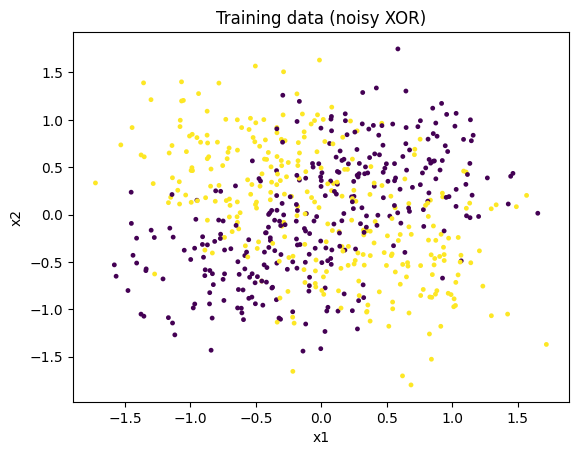

In [5]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def relu(z):
    return np.maximum(0.0, z)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_from_logits(z, y):
    t = np.maximum(z, 0) - z*y + np.log1p(np.exp(-np.abs(z)))
    return float(np.mean(t))

def train_val_split(x, y, val_ratio=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    N = x.shape[0]
    idx = rng.permutation(N)
    n_val = int(N*val_ratio)
    val_idx = idx[:n_val]
    tr_idx = idx[n_val:]
    return x[tr_idx], y[tr_idx], x[val_idx], y[val_idx]

def make_xor(N=600, noise=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    x = rng.uniform(-1, 1, size=(N, 2))
    y = ((x[:, 0] > 0) ^ (x[:, 1] > 0)).astype(float).reshape(-1, 1)
    x = x + rng.normal(0, noise, size=x.shape)
    return x, y

x, y = make_xor(N=800, noise=0.35, rng=rng)
x_tr, y_tr, x_va, y_va = train_val_split(x, y, val_ratio=0.25, rng=rng)
print('train shapes:', x_tr.shape, y_tr.shape)
print('val shapes  :', x_va.shape, y_va.shape)

plt.figure()
plt.scatter(x_tr[:,0], x_tr[:,1], c=y_tr[:,0], s=12, edgecolors='none')
plt.title('Training data (noisy XOR)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Step-by-step experiments
1. Train an under-capacity model (linear logistic regression) and observe underfitting.
2. Train a higher-capacity 1-hidden-layer MLP and observe overfitting risk.
3. Add L2 regularization and early stopping; compare validation curves.
4. Visualize decision boundaries and train/val loss trajectories.

In [6]:
def train_logreg(x_tr, y_tr, x_va, y_va, lr=0.8, steps=800):
    N, D = x_tr.shape
    W = rng.normal(0, 0.1, size=(D,1))
    b = np.zeros((1,1))
    trL, vaL = [], []
    for _ in range(steps):
        z = x_tr @ W + b
        a = sigmoid(z)
        dz = (a - y_tr)/N
        dW = x_tr.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        W -= lr*dW
        b -= lr*db
        trL.append(bce_from_logits(x_tr @ W + b, y_tr))
        vaL.append(bce_from_logits(x_va @ W + b, y_va))
    return W, b, np.array(trL), np.array(vaL)

def train_mlp_1h(x_tr, y_tr, x_va, y_va, H=32, lr=0.3, steps=1200, l2=0.0, patience=60):
    N, D = x_tr.shape
    W1 = rng.normal(0, 0.5, size=(D,H))
    b1 = np.zeros((1,H))
    W2 = rng.normal(0, 0.5, size=(H,1))
    b2 = np.zeros((1,1))

    trL, vaL = [], []
    best = np.inf
    best_params = None
    wait = 0
    for step in range(steps):
        # forward
        z1 = x_tr @ W1 + b1
        a1 = relu(z1)
        z2 = a1 @ W2 + b2  # logits

        # loss
        L_data = bce_from_logits(z2, y_tr)
        L_reg = l2*(np.sum(W1*W1) + np.sum(W2*W2))
        L = L_data + L_reg

        # backward (BCE with sigmoid: dz2 = (sigmoid(z2)-y)/N)
        a2 = sigmoid(z2)
        dz2 = (a2 - y_tr)/N
        dW2 = a1.T @ dz2 + 2*l2*W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ W2.T
        dz1 = da1 * (z1 > 0)
        dW1 = x_tr.T @ dz1 + 2*l2*W1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # update
        W1 -= lr*dW1
        b1 -= lr*db1
        W2 -= lr*dW2
        b2 -= lr*db2

        # track
        trL.append(L)
        va = bce_from_logits((relu(x_va @ W1 + b1) @ W2 + b2), y_va) + l2*(np.sum(W1*W1)+np.sum(W2*W2))
        vaL.append(va)

        # early stopping
        if va < best - 1e-4:
            best = va
            best_params = (W1.copy(), b1.copy(), W2.copy(), b2.copy())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_params is not None:
        W1, b1, W2, b2 = best_params
    return (W1, b1, W2, b2, np.array(trL), np.array(vaL))

# 1) Underfitting model
W_lr, b_lr, trL_lr, vaL_lr = train_logreg(x_tr, y_tr, x_va, y_va, lr=0.8, steps=900)
print('LogReg final train/val:', trL_lr[-1], vaL_lr[-1])

# 2) Higher capacity model (risk overfitting)
W1, b1, W2, b2, trL_m, vaL_m = train_mlp_1h(x_tr, y_tr, x_va, y_va, H=64, lr=0.35, steps=2000, l2=0.0, patience=120)
print('MLP(no reg) steps:', len(trL_m), 'final train/val:', trL_m[-1], vaL_m[-1])

# 3) Regularized + early stopping
W1r, b1r, W2r, b2r, trL_r, vaL_r = train_mlp_1h(x_tr, y_tr, x_va, y_va, H=64, lr=0.35, steps=2000, l2=1e-3, patience=120)
print('MLP(L2) steps:', len(trL_r), 'final train/val:', trL_r[-1], vaL_r[-1])

LogReg final train/val: 0.6917937640158728 0.6953540880122773
MLP(no reg) steps: 171 final train/val: 0.48781894666339476 0.4833720824279644
MLP(L2) steps: 2000 final train/val: 0.5123294185939089 0.5075575648828597


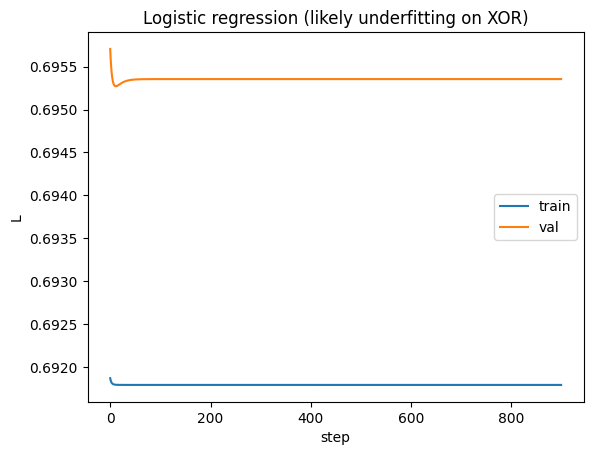

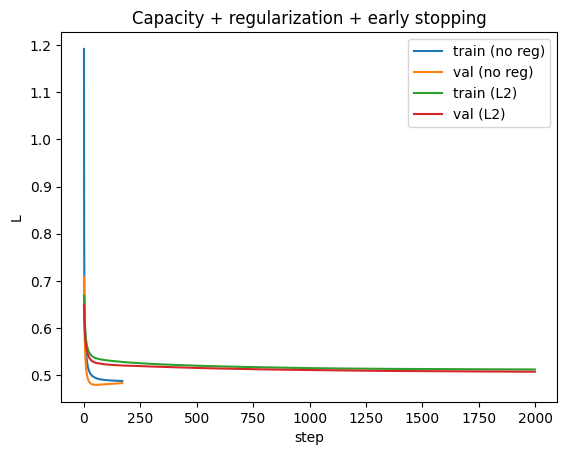

In [7]:
# Plot 1: loss curves (underfitting)
plt.figure()
plt.plot(trL_lr, label='train')
plt.plot(vaL_lr, label='val')
plt.title('Logistic regression (likely underfitting on XOR)')
plt.xlabel('step')
plt.ylabel('L')
plt.legend()
plt.show()

# Plot 2: loss curves (MLP no reg vs L2)
plt.figure()
plt.plot(trL_m, label='train (no reg)')
plt.plot(vaL_m, label='val (no reg)')
plt.plot(trL_r, label='train (L2)')
plt.plot(vaL_r, label='val (L2)')
plt.title('Capacity + regularization + early stopping')
plt.xlabel('step')
plt.ylabel('L')
plt.legend()
plt.show()

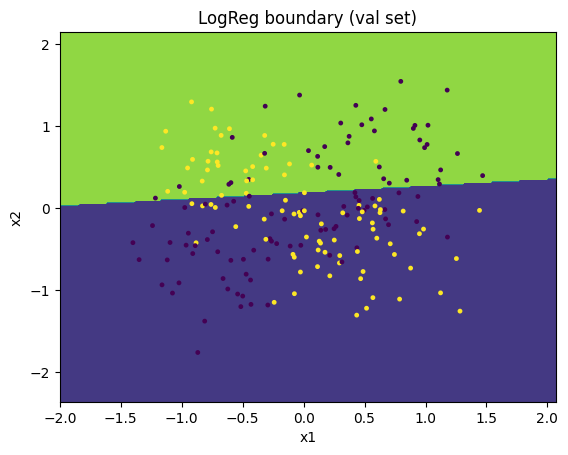

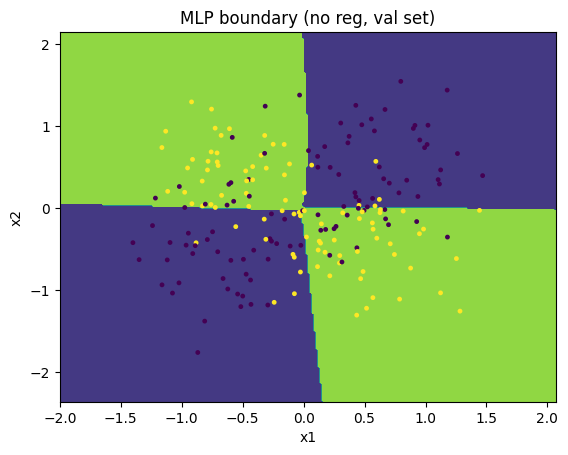

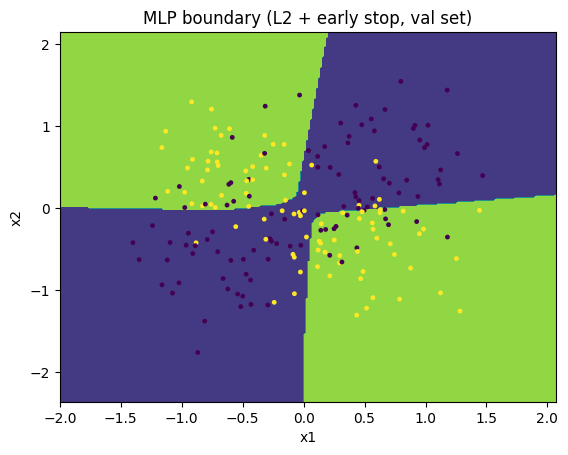

In [8]:
def plot_boundary_score(x, y, score_fn, title):
    x1_min, x1_max = x[:,0].min()-0.6, x[:,0].max()+0.6
    x2_min, x2_max = x[:,1].min()-0.6, x[:,1].max()+0.6
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 250), np.linspace(x2_min, x2_max, 250))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    s = score_fn(grid).reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, s >= 0.5, levels=2)
    plt.scatter(x[:,0], x[:,1], c=y[:,0], s=12, edgecolors='none')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Visual boundaries on validation set
plot_boundary_score(x_va, y_va, lambda u: sigmoid(u @ W_lr + b_lr)[:,0], 'LogReg boundary (val set)')
plot_boundary_score(x_va, y_va, lambda u: sigmoid(relu(u @ W1 + b1) @ W2 + b2)[:,0], 'MLP boundary (no reg, val set)')
plot_boundary_score(x_va, y_va, lambda u: sigmoid(relu(u @ W1r + b1r) @ W2r + b2r)[:,0], 'MLP boundary (L2 + early stop, val set)')

## Reflection questions
1. What did underfitting look like in both loss curves and boundary shape?
2. How did adding capacity change the training loss trajectory?
3. Why does L2 regularization often smooth decision boundaries?
4. How does early stopping behave like a regularizer?
5. If validation loss improves but accuracy does not, what might be happening?

## Optional extensions
1. Reduce training set size and observe overfitting earlier.
2. Try smaller hidden width (H=8,16) and compare.
3. Add label noise (flip a fraction of y) and observe irreducible error.

## Summary
- Underfitting: model too simple; train loss stays high.
- Overfitting: train improves while val worsens.
- Capacity interacts with data noise and dataset size.
- L2 and early stopping improve generalization in practice.
- Next: splitting correctly and avoiding leakage.